In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calculations

In [7]:
headers = ["timestamp", "duration", "stability", "activity", "activity_confidence", "calibration_status", "w", "x", "y", "z"]
data = pd.read_csv('prototype_data/data.csv', names=headers)

data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data['weekday'] = data['timestamp'].dt.day_name()
data['date'] = data['timestamp'].dt.date
data['hour'] = data['timestamp'].dt.hour
data['hour_minute'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data = data[data['timestamp'] >= pd.Timestamp('2024-01-01')]

data[['roll', 'pitch', 'yaw']] = data.apply(lambda row: calculations.quaternion_to_euler(row['w'], row['x'], row['y'], row['z']), axis=1, result_type='expand')

In [8]:
data

,timestamp,duration,stability,activity,activity_confidence,calibration_status,w,x,y,z,weekday,date,hour,hour_minute,roll,pitch,yaw
0,2024-06-24 08:05:20,157,In motion,In-Vehicle,92,2,0.366577,0.559509,0.626770,0.399597,Monday,2024-06-24,8,8.083333,114.323468,-0.708386,83.966903
1,2024-06-24 08:11:01,154,In motion,Still,74,2,0.362854,0.587463,0.627075,0.360474,Monday,2024-06-24,8,8.183333,118.489462,-1.807692,87.339682
2,2024-06-24 08:12:31,154,In motion,Still,92,3,-0.045166,-0.084228,0.411926,0.906189,Monday,2024-06-24,8,8.200000,49.398442,-6.629249,-8.758405
3,2024-06-24 08:16:12,186,In motion,Still,44,3,0.571533,0.243469,0.237366,0.746765,Monday,2024-06-24,8,8.266667,39.462557,5.296509,76.757793
4,2024-06-24 08:16:20,148,Stable,Still,74,3,0.341736,0.024719,0.283386,0.895691,Monday,2024-06-24,8,8.266667,32.040664,-8.592746,39.295561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2024-06-28 11:06:25,248,Stable,Still,97,2,0.172180,0.383972,0.792175,0.442078,Friday,2024-06-28,11,11.100000,123.442085,3.824130,49.661682
3332,2024-06-28 11:06:31,248,Stable,Still,97,2,0.025330,0.012878,0.879944,0.474243,Friday,2024-06-28,11,11.100000,123.312047,-1.854517,2.677436
3333,2024-06-28 11:06:38,210,Stable,Still,97,2,0.232727,0.574280,0.699829,0.355347,Friday,2024-06-28,11,11.100000,129.889655,4.726522,76.534100
3334,2024-06-28 11:06:44,192,In motion,Still,77,2,-0.008362,0.018127,0.898926,0.437683,Friday,2024-06-28,11,11.100000,128.099907,1.770745,1.448705


In [9]:
filter_calibration_status = True
if filter_calibration_status:
    data = data[data['calibration_status'] >= 2]

/var/folders/bb/5xjn46cj43b1fstx6lm5mj740000gn/T/ipykernel_53104/1320053058.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')


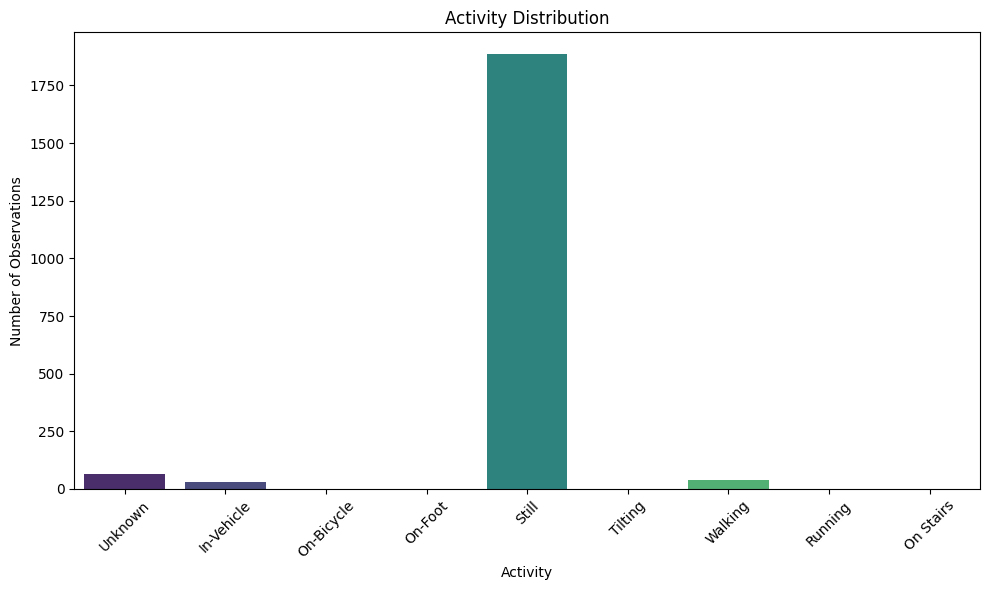

In [10]:
all_activities = ['Unknown', 'In-Vehicle', 'On-Bicycle', 'On-Foot', 'Still', 'Tilting', 'Walking', 'Running', 'On Stairs']
activity_counts = data['activity'].value_counts().reindex(all_activities, fill_value=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')
plt.title('Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/bb/5xjn46cj43b1fstx6lm5mj740000gn/T/ipykernel_53104/3993209728.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stability_counts.index, y=stability_counts.values, palette='viridis')


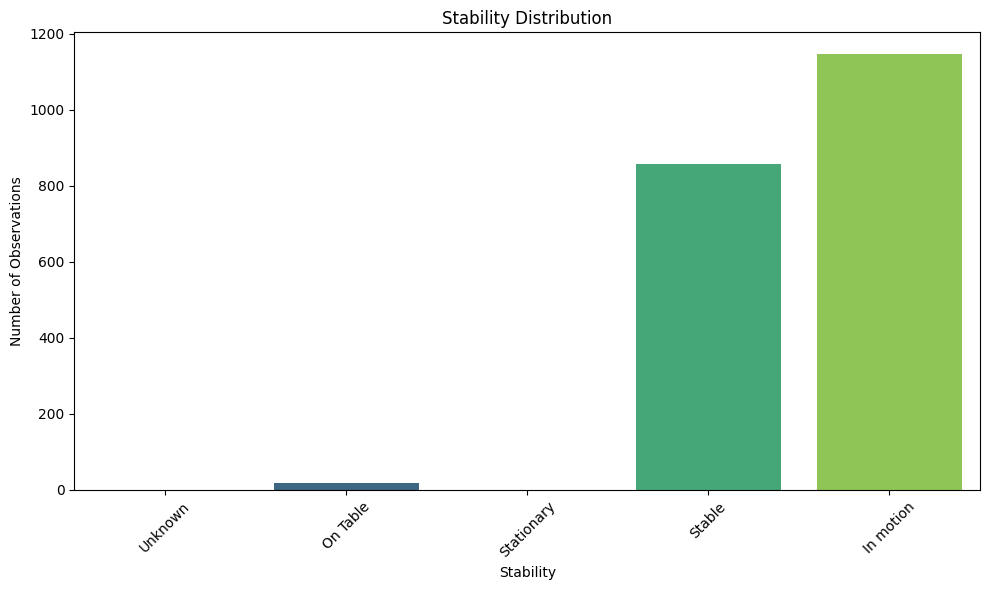

In [11]:
all_stability_statuses = ['Unknown', 'On Table', 'Stationary', 'Stable', 'In motion']
stability_counts = data['stability'].value_counts().reindex(all_stability_statuses, fill_value=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=stability_counts.index, y=stability_counts.values, palette='viridis')
plt.title('Stability Distribution')
plt.xlabel('Stability')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/bb/5xjn46cj43b1fstx6lm5mj740000gn/T/ipykernel_53104/3120030763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=calibration_counts.index, y=calibration_counts.values, palette='viridis')


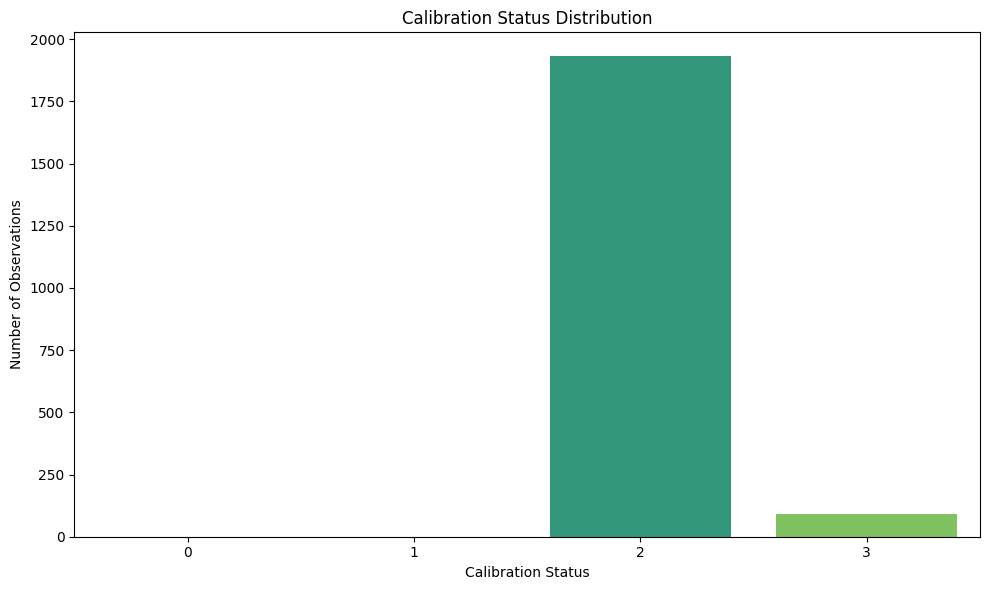

In [12]:
all_calibration_statuses = [0, 1, 2, 3]
calibration_counts = data['calibration_status'].value_counts().reindex(all_calibration_statuses, fill_value=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=calibration_counts.index, y=calibration_counts.values, palette='viridis')
plt.title('Calibration Status Distribution')
plt.xlabel('Calibration Status')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
min_duration = data['duration'].min()
max_duration = data['duration'].max()
avg_duration = data['duration'].mean()

duration_table = pd.DataFrame({
    'Metric': ['Minimum Duration', 'Maximum Duration', 'Average Duration'],
    'Duration (ms)': [min_duration, max_duration, avg_duration]
})

duration_table

,Metric,Duration (ms)
0,Minimum Duration,79.00000
1,Maximum Duration,638.00000
2,Average Duration,166.12364


In [14]:
start_date = data['timestamp'].min().date()
end_date = data['timestamp'].max().date()
total_days_tracked = (end_date - start_date).days + 1

total_observations = len(data)

daily_counts = data['timestamp'].dt.date.value_counts().sort_index()
average_daily_observations = daily_counts.mean()

all_dates = pd.date_range(start=start_date, end=end_date).date
days_without_observations = len(set(all_dates) - set(daily_counts.index))

summary_table = pd.DataFrame({
    'Metric': ['Duration (days)', 'Number of Observations', 'Average Daily Observations', 'Days Without Observations'],
    'Value': [total_days_tracked, total_observations, average_daily_observations, days_without_observations]
})

summary_table

,Metric,Value
0,Duration (days),5.0
1,Number of Observations,2022.0
2,Average Daily Observations,404.4
3,Days Without Observations,0.0


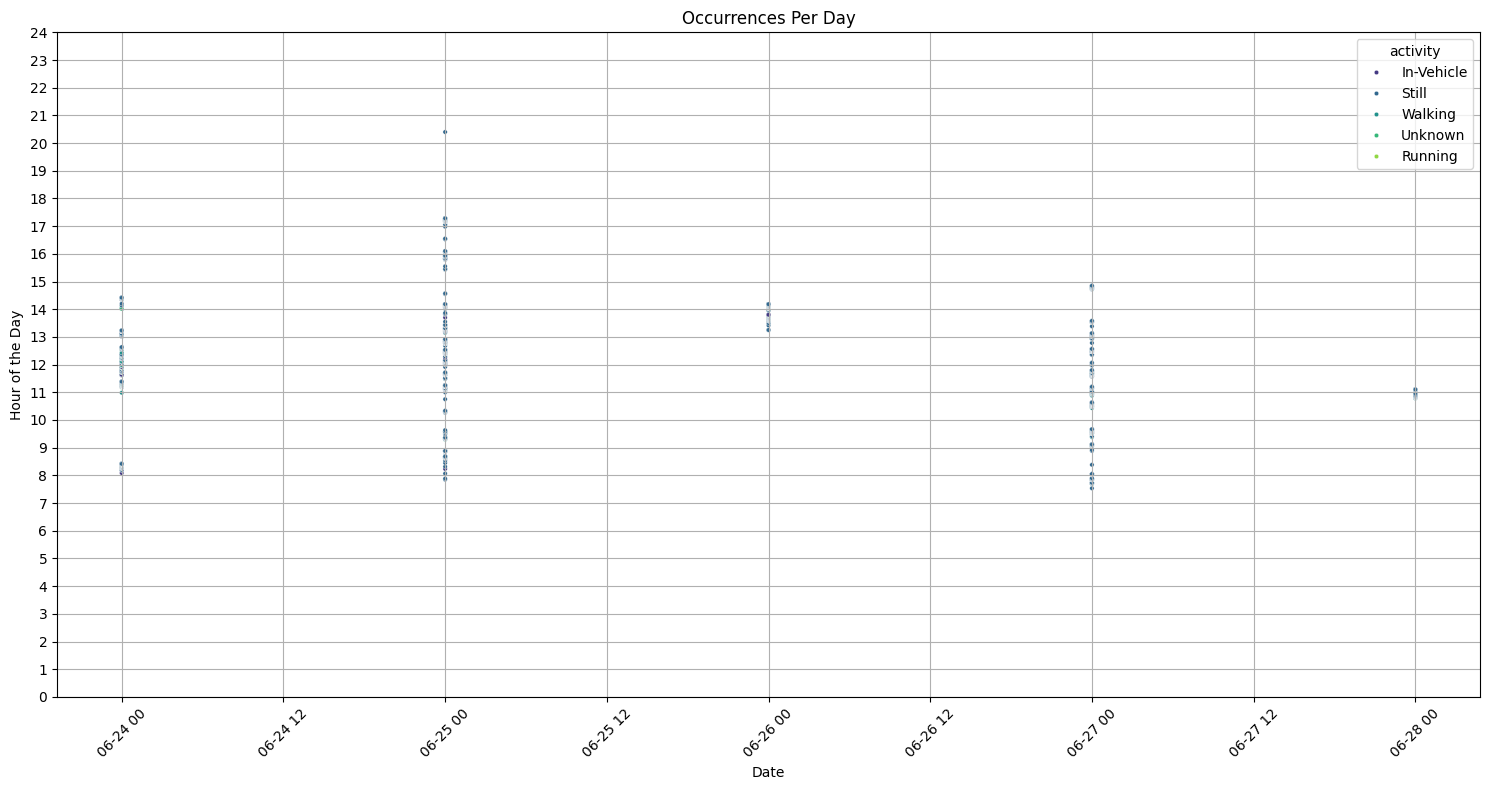

In [15]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=data, x='date', y='hour_minute', hue='activity', palette='viridis', s=10)

unique_dates = data['date'].unique()
for single_date in unique_dates:
    if pd.to_datetime(single_date).weekday() >= 5:
        plt.axvspan(single_date, single_date, color='gray', alpha=0.3)

plt.title('Occurrences Per Day')
plt.xlabel('Date')
plt.ylabel('Hour of the Day')
plt.xticks(rotation=45)
plt.yticks(range(0, 25))
plt.grid(True)

plt.tight_layout()
plt.show()

/var/folders/bb/5xjn46cj43b1fstx6lm5mj740000gn/T/ipykernel_53104/1045424305.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['observation'] = data.apply(classify_observation, axis=1)


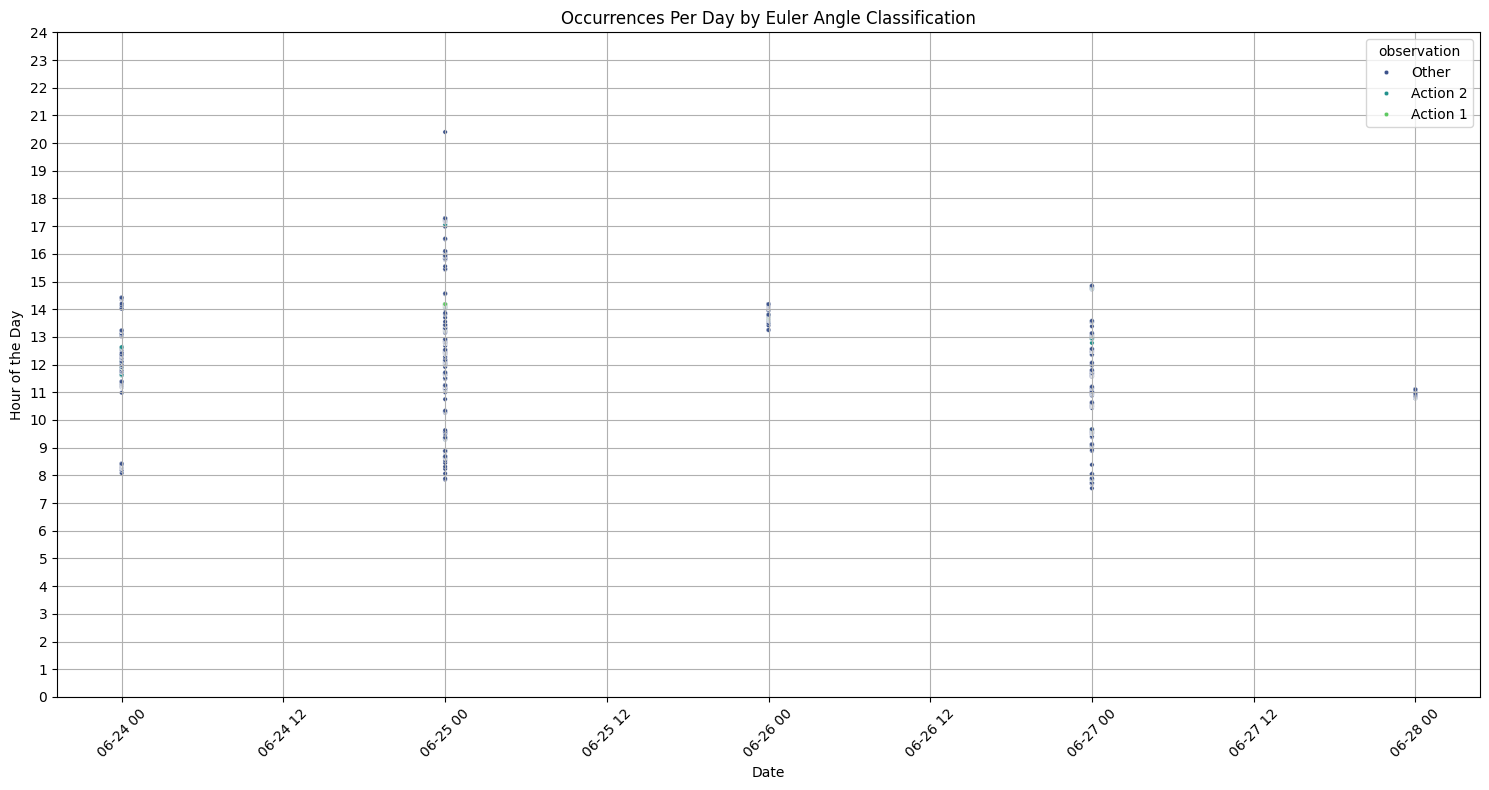

In [16]:
# Classify observation based on Euler angles
def classify_observation(row):
    if 40 <= row['pitch'] <= 50:
        return 'Action 1'
    elif 5 <= row['pitch'] <= 15:
        return 'Action 2'
    else:
        return 'Other'

data['observation'] = data.apply(classify_observation, axis=1)

plt.figure(figsize=(15, 8))

sns.scatterplot(data=data, x='date', y='hour_minute', hue='observation', palette='viridis', s=10)

unique_dates = data['date'].unique()
for single_date in unique_dates:
    if pd.to_datetime(single_date).weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        plt.axvspan(single_date, single_date, color='gray', alpha=0.3)

plt.title('Occurrences Per Day by Euler Angle Classification')
plt.xlabel('Date')
plt.ylabel('Hour of the Day')
plt.xticks(rotation=45)
plt.yticks(range(0, 25))
plt.grid(True)

plt.tight_layout()
plt.show()

/var/folders/bb/5xjn46cj43b1fstx6lm5mj740000gn/T/ipykernel_53104/3457358285.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_weekday_counts.index, y=average_weekday_counts.values, palette='viridis')


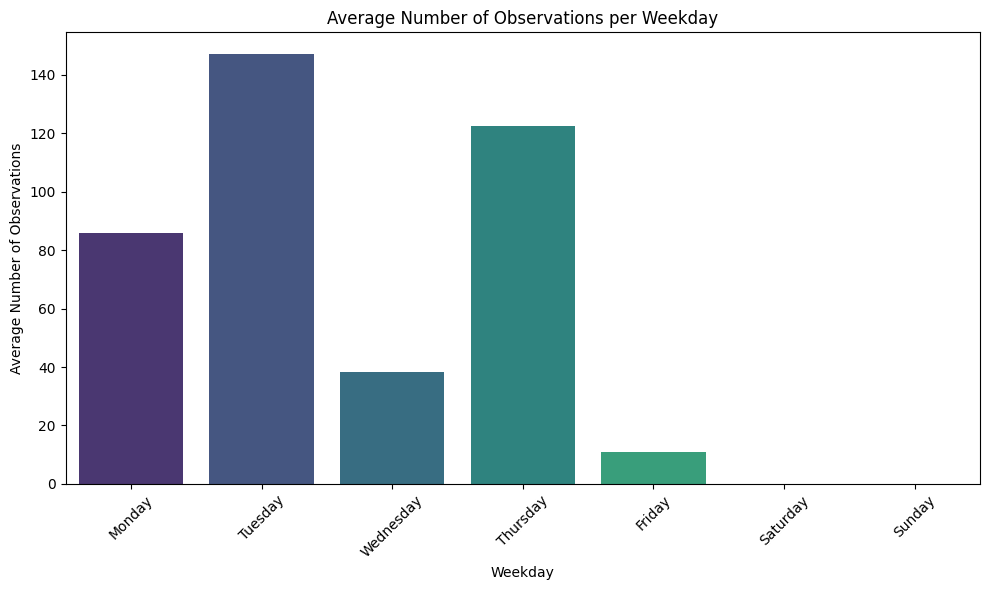

In [17]:
all_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = data['weekday'].value_counts().reindex(all_weekdays, fill_value=0)

average_weekday_counts = weekday_counts / len(data['timestamp'].dt.date.unique())

plt.figure(figsize=(10, 6))
sns.barplot(x=average_weekday_counts.index, y=average_weekday_counts.values, palette='viridis')
plt.title('Average Number of Observations per Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Number of Observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/bb/5xjn46cj43b1fstx6lm5mj740000gn/T/ipykernel_53104/4151630925.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette='viridis')


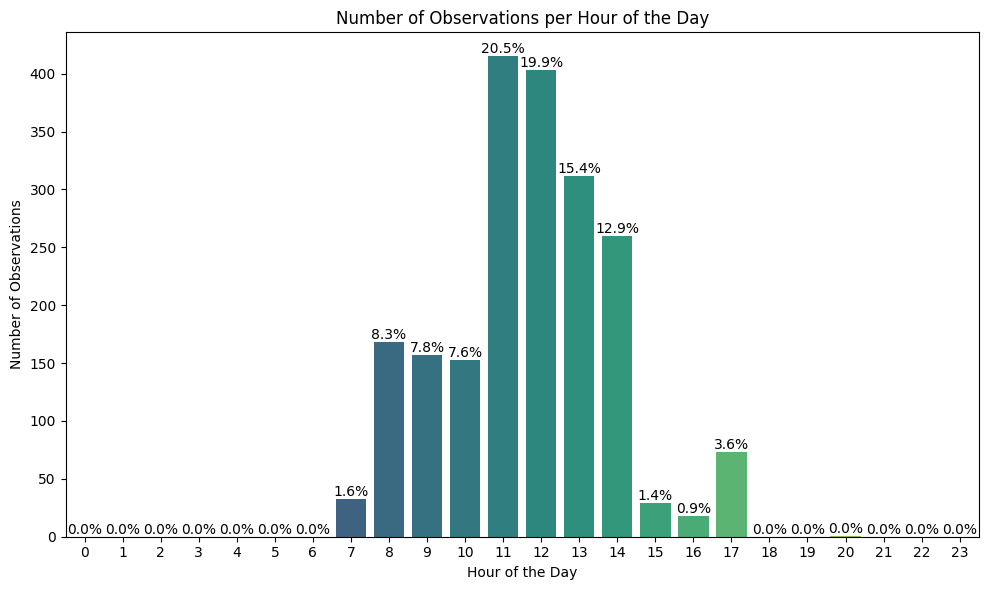

In [18]:
all_hours = range(24)
hourly_counts = data['hour'].value_counts().reindex(all_hours, fill_value=0)

total_observations = hourly_counts.sum()
hourly_percentage = (hourly_counts / total_observations) * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette='viridis')

for i in range(len(hourly_counts)):
    ax.text(i, hourly_counts[i], f'{hourly_percentage[i]:.1f}%', ha='center', va='bottom')

plt.title('Number of Observations per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Observations')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()